In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
%matplotlib inline

In [2]:
df1 = pd.read_csv('ACCOUNTS.csv')
df2 = pd.read_csv('DEMOGRAPHICS.csv')
df3 = pd.read_csv('LOANS.csv')

In [3]:
df1

,ID,CHECKING_BALANCE,CREDIT_HISTORY,EXISTING_SAVINGS,EXISTING_CREDITS_COUNT
0,291655,-566.53,ALL_CREDITS_PAID_BACK,36.42,1.0
1,657079,-1673.16,CREDITS_PAID_TO_DATE,22.9,1.0
2,256050,NO_CHECKING,CREDITS_PAID_TO_DATE,450.35,2.0
3,1039151,-1471.03,PRIOR_PAYMENTS_DELAYED,805.71,2.0
4,1002660,NO_CHECKING,CREDITS_PAID_TO_DATE,295.03,1.0
...,...,...,...,...,...
2472,636739,163.82,CREDITS_PAID_TO_DATE,472.11,1.0
2473,919733,14324.23,PRIOR_PAYMENTS_DELAYED,18652.44,1.0
2474,115839,130.13,PRIOR_PAYMENTS_DELAYED,726.78,2.0
2475,1128684,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,UNKNOWN,1.0


In [4]:
df2

,ID,SEX,AGE,JOB_TYPE,DEPENDENTS,TELEPHONE,FOREIGN_WORKER,EMPLOYMENT_DURATION,PROPERTY,HOUSING,CURRENT_RESIDENCE_DURATION
0,24252,M,47.0,3.0,1.0,0.0,1.0,14.0,SAVINGS_INSURANCE,OWN,3.0
1,1002018,M,19.0,3.0,1.0,0.0,1.0,0.0,SAVINGS_INSURANCE,RENT,2.0
2,1240455,F,50.0,2.0,1.0,1.0,1.0,7.0,UNKNOWN,OWN,3.0
3,107799,M,35.0,3.0,1.0,0.0,1.0,0.0,REAL_ESTATE,OWN,2.0
4,184883,M,40.0,1.0,1.0,0.0,1.0,9.0,CAR_OTHER,OWN,4.0
...,...,...,...,...,...,...,...,...,...,...,...
3931,636739,F,41.0,0.0,1.0,0.0,1.0,7.0,CAR_OTHER,OWN,3.0
3932,919733,M,46.0,3.0,1.0,1.0,1.0,11.0,SAVINGS_INSURANCE,OWN,3.0
3933,115839,M,28.0,3.0,1.0,1.0,1.0,7.0,CAR_OTHER,RENT,1.0
3934,1128684,M,46.0,0.0,1.0,0.0,1.0,7.0,CAR_OTHER,RENT,3.0


In [5]:
df3

,ID,PAYMENT_TERM,INSTALLMENT_PLANS,INSTALLMENT_PERCENT,LOAN_PURPOSE,LOAN_AMOUNT,OTHERS_ON_LOAN,ALLOW
0,610339,713.0,STORES,3.0,CAR_USED,3103.0,NONE,1
1,109167,341.0,STORES,1.0,CAR_NEW,716.0,NONE,1
2,823322,868.0,NONE,4.0,APPLIANCES,4333.0,NONE,1
3,322224,310.0,STORES,2.0,FURNITURE,250.0,NONE,1
4,912693,620.0,NONE,2.0,CAR_USED,2454.0,NONE,0
...,...,...,...,...,...,...,...,...
3994,636739,450.0,BANK,3.0,CAR_NEW,3007.0,CO-APPLICANT,0
3995,919733,510.0,NONE,4.0,VACATION,4191.0,GUARANTOR,1
3996,115839,124.0,STORES,1.0,FURNITURE,250.0,NONE,1
3997,1128684,961.0,BANK,3.0,BUSINESS,5172.0,NONE,1


## Visão Geral

Compreender cada informação coletada é essencial para um possível modelo que será gerado. Nesse sentido, gera-se uma análise inicial de cada variável (ou coluna) foi coletada e justifica-se o porque dessa variável não será considerada no modelo ou até mesmo, qual tratamento de dados será utilizado nela.

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2477 entries, 0 to 2476
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      2477 non-null   int64  
 1   CHECKING_BALANCE        2467 non-null   object 
 2   CREDIT_HISTORY          2462 non-null   object 
 3   EXISTING_SAVINGS        2467 non-null   object 
 4   EXISTING_CREDITS_COUNT  2463 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 96.9+ KB


A função <strong>info()</strong> já mostra um resumo geral do comportamento dos dados, apesar de superficial é possível observar que os dados estão desbalanceados, ou seja, será necessário realizar uma análise exploratória individual de cada variável e posteriormente realizar um tratamento e limpeza de informações que não terão impacto no modelo de classificação que se almeja construir.

## Análise Inicial de Dados 1 - 'accounts.csv'


In [7]:
df1.corr() 

,ID,EXISTING_CREDITS_COUNT
ID,1.000000,-0.003681
EXISTING_CREDITS_COUNT,-0.003681,1.000000


In [8]:
df1[df1['CHECKING_BALANCE']=='NO_CHECKING']

,ID,CHECKING_BALANCE,CREDIT_HISTORY,EXISTING_SAVINGS,EXISTING_CREDITS_COUNT
2,256050,NO_CHECKING,CREDITS_PAID_TO_DATE,450.35,2.0
4,1002660,NO_CHECKING,CREDITS_PAID_TO_DATE,295.03,1.0
6,1096578,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,421.96,1.0
10,1136574,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,383.57,1.0
12,1268579,NO_CHECKING,OUTSTANDING_CREDIT,572.37,2.0
...,...,...,...,...,...
2468,827553,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,615.54,2.0
2469,145488,NO_CHECKING,OUTSTANDING_CREDIT,33154.86,2.0
2470,178072,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,726.26,2.0
2475,1128684,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,UNKNOWN,1.0


In [9]:
df1[df1['EXISTING_SAVINGS']=='UNKNOWN']

,ID,CHECKING_BALANCE,CREDIT_HISTORY,EXISTING_SAVINGS,EXISTING_CREDITS_COUNT
23,1049084,NO_CHECKING,OUTSTANDING_CREDIT,UNKNOWN,2.0
26,1177670,NO_CHECKING,OUTSTANDING_CREDIT,UNKNOWN,2.0
31,584707,NO_CHECKING,OUTSTANDING_CREDIT,UNKNOWN,2.0
32,100984,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,UNKNOWN,3.0
36,29700,NO_CHECKING,OUTSTANDING_CREDIT,UNKNOWN,2.0
...,...,...,...,...,...
2380,514189,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,UNKNOWN,2.0
2429,816269,NO_CHECKING,OUTSTANDING_CREDIT,UNKNOWN,2.0
2438,1152672,97.91,OUTSTANDING_CREDIT,UNKNOWN,2.0
2475,1128684,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,UNKNOWN,1.0


### 1) Com relação aos saldo da conta de cada cliente, qual a relação entre verificados e não verificados? 

In [10]:
# Dividi-se o dataset em 2, onde a variável check é compreendida pelas informações numéricas.
no_check = len(df1[df1[u'CHECKING_BALANCE'] == 'NO_CHECKING'])
check = len(df1[df1[u'CHECKING_BALANCE'] != 'NO_CHECKING'])

new_df = {'NO_CHECKING': [no_check], 'CHECKING': [check]}

checking_balance = pd.DataFrame(data=new_df)

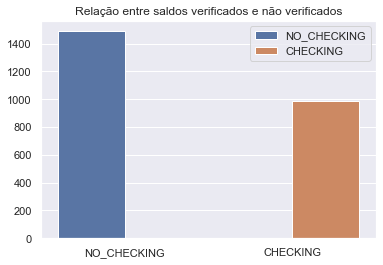

In [11]:
sns.set(style="darkgrid")

fig = sns.barplot(x=list(checking_balance) ,y=[checking_balance['CHECKING'].iloc[0],checking_balance['NO_CHECKING'].iloc[0]],hue=list(checking_balance))
plt.title("Relação entre saldos verificados e não verificados")
plt.show(fig)

## 2) Quais características estão presentes na coluna 'Histórico de Crédito'?

In [12]:
df1['CREDIT_HISTORY'].unique()

array(['ALL_CREDITS_PAID_BACK', 'CREDITS_PAID_TO_DATE',
       'PRIOR_PAYMENTS_DELAYED', 'OUTSTANDING_CREDIT', 'NO_CREDITS', nan],
      dtype=object)

## 3) Qual a relação entre economias conhecidas e desconhecidas dos clientes com o banco?

In [13]:
# Dividi-se o dataset em 2, onde a variável check é compreendida pelas informações numéricas.
exis = len(df1[df1[u'EXISTING_SAVINGS'] != 'UNKNOWN'])
no_exis = len(df1[df1[u'EXISTING_SAVINGS'] == 'UNKNOWN'])

new_df2 = {'EXISTING_SAVINGS': [exis], 'NO_EXISTING_SAVINGS': [no_exis]}

check_savings = pd.DataFrame(data=new_df2)

In [14]:
check_savings

,EXISTING_SAVINGS,NO_EXISTING_SAVINGS
0,2301,176


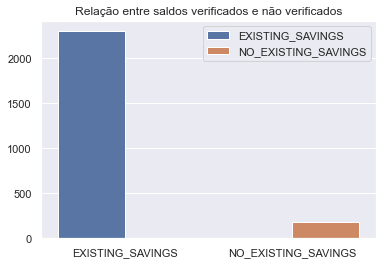

In [15]:
sns.set(style="darkgrid")

fig = sns.barplot(x=list(check_savings) ,y=[check_savings['EXISTING_SAVINGS'].iloc[0],
                                            check_savings['NO_EXISTING_SAVINGS'].iloc[0]],
                                            hue=list(check_savings))
plt.title("Relação entre saldos verificados e não verificados")
plt.show(fig)

In [16]:
df1[df1['EXISTING_CREDITS_COUNT'].isnull()]

,ID,CHECKING_BALANCE,CREDIT_HISTORY,EXISTING_SAVINGS,EXISTING_CREDITS_COUNT
34,1205053,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,600.14,NaN
38,245917,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,1788.77,NaN
193,205835,-665.67,ALL_CREDITS_PAID_BACK,441.07,NaN
295,501397,-99.73,ALL_CREDITS_PAID_BACK,24.02,NaN
461,676771,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,UNKNOWN,NaN
770,463004,590.68,CREDITS_PAID_TO_DATE,15.83,NaN
1127,839628,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,813.85,NaN
1232,1135727,0.5,ALL_CREDITS_PAID_BACK,78.54,NaN
1428,794570,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,UNKNOWN,NaN
1498,773770,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,151.43,NaN


## Análise Inicial de Dados 2 - 'demographics.csv'

In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3936 entries, 0 to 3935
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          3936 non-null   int64  
 1   SEX                         3920 non-null   object 
 2   AGE                         3918 non-null   float64
 3   JOB_TYPE                    3910 non-null   float64
 4   DEPENDENTS                  3915 non-null   float64
 5   TELEPHONE                   3915 non-null   float64
 6   FOREIGN_WORKER              3909 non-null   float64
 7   EMPLOYMENT_DURATION         3923 non-null   float64
 8   PROPERTY                    3918 non-null   object 
 9   HOUSING                     3912 non-null   object 
 10  CURRENT_RESIDENCE_DURATION  3917 non-null   float64
dtypes: float64(7), int64(1), object(3)
memory usage: 338.4+ KB


## Qual o sexo dos clientes?

In [33]:
df2['SEX'].value_counts()

M    2419
F    1501
Name: SEX, dtype: int64

In [34]:
df2['SEX'].fillna("NR", inplace = True)

In [52]:
# Dividi-se o dataset em 2, onde a variável check é compreendida pelas informações numéricas.
sex_M = len(df2[df2[u'SEX'] == 'M'])
sex_F = len(df2[df2[u'SEX'] == 'F'])
sex_NR = len(df2[df2[u'SEX'] == 'NR']) # não respondido (NaN)

new_df2 = {'M': [sex_M], 'F': [sex_F]}

check_sex = pd.DataFrame(data=new_df2)

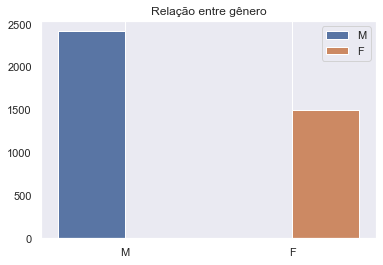

In [87]:
sns.set(style="darkgrid")

fig = sns.barplot(x=list(check_sex),
                  y=[check_sex['M'].iloc[0],
                     check_sex['F'].iloc[0]],
                     hue=list(check_sex))
plt.grid(None)
plt.title("Relação entre gênero")
plt.rcParams["figure.figsize"] = (4,6)
plt.show(fig)

Nesse caso, baseado nos dados optamos por apenas apresentar a relação entre o sexo Masculino e Feminino para dados bancários. Vale ressaltar que o índice percentual de pessoas que ou não responderam, ou que por alguma instabilidade do sistema não foi salva é de 0.4% no total (16 registros sem resposta). Mas isso não é tudo, é importante entender também qual amostra está a nossa disposição, no caso, essa amostra tem exatos 3936 dados.

## Qual a distribuição a cerca da idade dos nossos clientes?

Para auxiliar nessa tarefa, criamos alguns filtros para compreender melhor a qual faixa etária os clientes da BanTotal pertencem. 

In [80]:
#df2['AGE'].value_counts()

C:\Users\danil\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


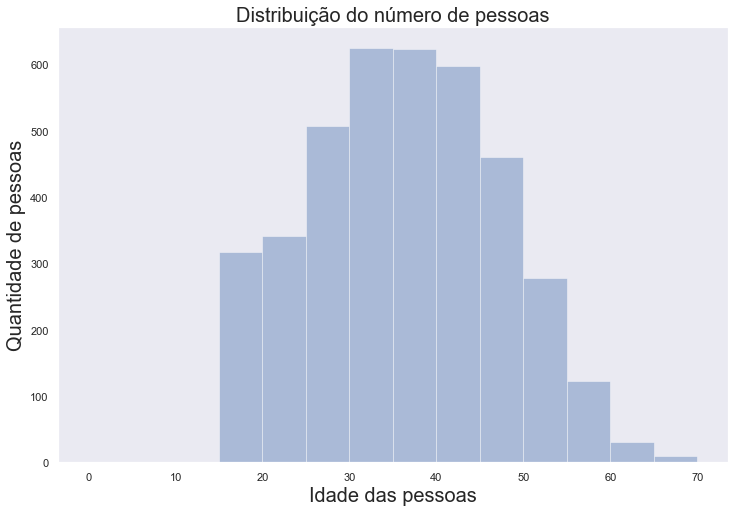

In [102]:
ax = sns.distplot(df2.AGE, kde = False, 
                  bins = [i*5 for(i) in range (15)])
ax.set_xlabel("Idade das pessoas", 
              fontsize = 20, 
              position=(0.5,0))

ax.set_ylabel("Quantidade de pessoas", 
              fontsize = 20, 
              position=(0.5,0.5))

ax.grid(None)

ax.set_title('Distribuição do número de pessoas', 
             fontsize = 20)

ax.figure.set_size_inches(12,8)

## Qual a distribuição que indica quantos dependentes nossos clientes têm?



In [90]:
df2['DEPENDENTS'].value_counts()

1.0    3284
2.0     631
Name: DEPENDENTS, dtype: int64

In [100]:
dep1 = len(df2[df2[u'DEPENDENTS'] == 1.0])
dep2 = len(df2[df2[u'DEPENDENTS'] == 2.0])

new_df3 = {'1.0': [dep1], '2.0': [dep2]}

check_dependence = pd.DataFrame(data=new_df3)
check_dependence

,1.0,2.0
0,3284,631


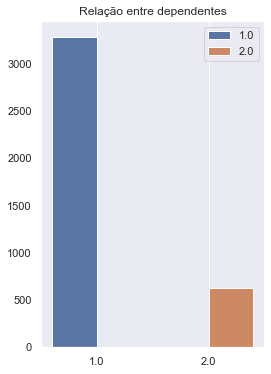

In [104]:
sns.set(style="darkgrid")

fig = sns.barplot(x=list(check_dependence),
                  y=[check_dependence['1.0'].iloc[0],
                     check_dependence['2.0'].iloc[0]],
                     hue=list(check_dependence))
plt.grid(None)
plt.title("Relação entre dependentes")
plt.rcParams["figure.figsize"] = (4,6)
plt.show(fig)

## O cliente tem telefone registrado no sistema?

0 - não

1 - sim


In [106]:
df2['TELEPHONE'].value_counts()

0.0    2302
1.0    1613
Name: TELEPHONE, dtype: int64

In [124]:
phone1 = len(df2[df2[u'TELEPHONE'] == 0.0])
phone2 = len(df2[df2[u'TELEPHONE'] == 1.0])

new_df4 = {'Sim': [phone1], 'Não': [phone2]}

check_phone = pd.DataFrame(data=new_df4)

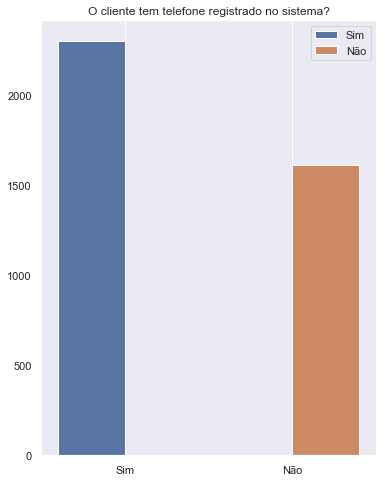

In [125]:
sns.set(style="darkgrid")

fig = sns.barplot(x=list(check_phone),
                  y=[check_phone['Sim'].iloc[0],
                     check_phone['Não'].iloc[0]],
                     hue=list(check_phone))
plt.grid(None)
plt.title("O cliente tem telefone registrado no sistema?")
plt.rcParams["figure.figsize"] = (6,8)
plt.show(fig)

## O cliente é um trabalhador estrangeiro?



In [126]:
df2['FOREIGN_WORKER'].value_counts()

1.0    3814
0.0      95
Name: FOREIGN_WORKER, dtype: int64

In [127]:
w1 = len(df2[df2[u'FOREIGN_WORKER'] == 0.0])
w2 = len(df2[df2[u'FOREIGN_WORKER'] == 1.0])

new_df4 = {'Sim': [w2], 'Não': [w1]}

check_worker = pd.DataFrame(data=new_df4)

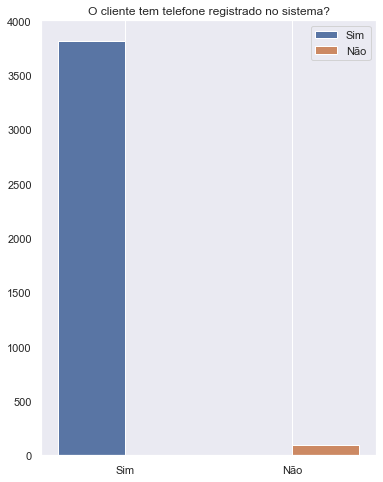

In [129]:
sns.set(style="darkgrid")

fig = sns.barplot(x=list(check_worker),
                  y=[check_worker['Sim'].iloc[0],
                     check_worker['Não'].iloc[0]],
                     hue=list(check_worker))
plt.grid(None)
plt.title("O cliente tem telefone registrado no sistema?")
plt.rcParams["figure.figsize"] = (6,8)
plt.show(fig)

# Duração do Trabalho

In [132]:
df2['EMPLOYMENT_DURATION'].value_counts()

0.0     929
5.0     390
7.0     372
6.0     351
1.0     314
3.0     290
2.0     275
4.0     275
8.0     192
9.0     180
10.0    143
11.0     90
12.0     73
13.0     24
14.0     11
15.0     10
16.0      2
18.0      1
17.0      1
Name: EMPLOYMENT_DURATION, dtype: int64

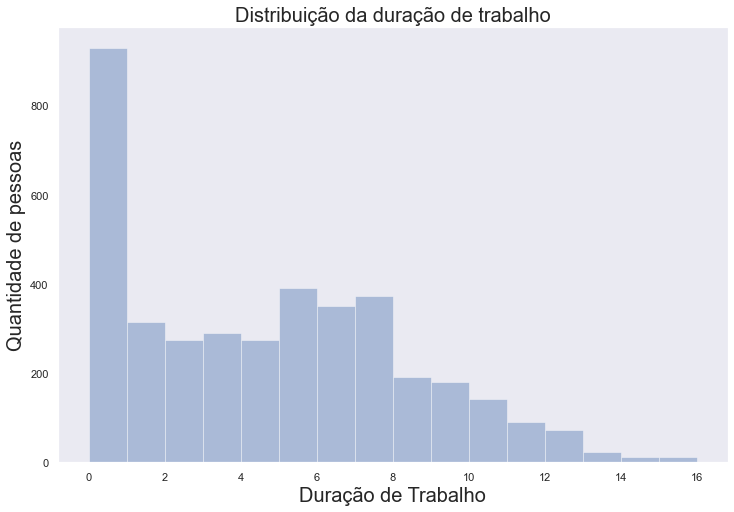

In [138]:
ax = sns.distplot(df2.EMPLOYMENT_DURATION, kde = False, 
                  bins = [i for(i) in range (17)])

ax.set_xlabel("Duração de Trabalho", 
              fontsize = 20, 
              position=(0.5,0))

ax.set_ylabel("Quantidade de pessoas", 
              fontsize = 20, 
              position=(0.5,0.5))

ax.grid(None)

ax.set_title('Distribuição da duração de trabalho', 
             fontsize = 20)

ax.figure.set_size_inches(12,8)

## Propriedade

In [140]:
df2['PROPERTY'].unique()

array(['SAVINGS_INSURANCE', 'UNKNOWN', 'REAL_ESTATE', 'CAR_OTHER', nan],
      dtype=object)

## Habitação

In [141]:
df2['HOUSING'].unique()

array(['OWN', 'RENT', 'FREE', nan], dtype=object)

## Duração de Residência Atual

In [144]:
df2['CURRENT_RESIDENCE_DURATION'].value_counts()

3.0    1304
2.0     986
4.0     854
1.0     486
5.0     284
6.0       3
Name: CURRENT_RESIDENCE_DURATION, dtype: int64

In [145]:
crd1 = len(df2[df2[u'FOREIGN_WORKER'] == 1.0])
crd2 = len(df2[df2[u'CURRENT_RESIDENCE_DURATION'] == 2.0])
crd3 = len(df2[df2[u'CURRENT_RESIDENCE_DURATION'] == 3.0])
crd4 = len(df2[df2[u'CURRENT_RESIDENCE_DURATION'] == 4.0])
crd5 = len(df2[df2[u'CURRENT_RESIDENCE_DURATION'] == 5.0])
crd6 = len(df2[df2[u'CURRENT_RESIDENCE_DURATION'] == 6.0])

new_df5 = {'1': [crd1], '2': [crd2], '3': [crd3], '4': [crd4], '5': [crd5], '6': [crd6]}

check_crd = pd.DataFrame(data=new_df5)

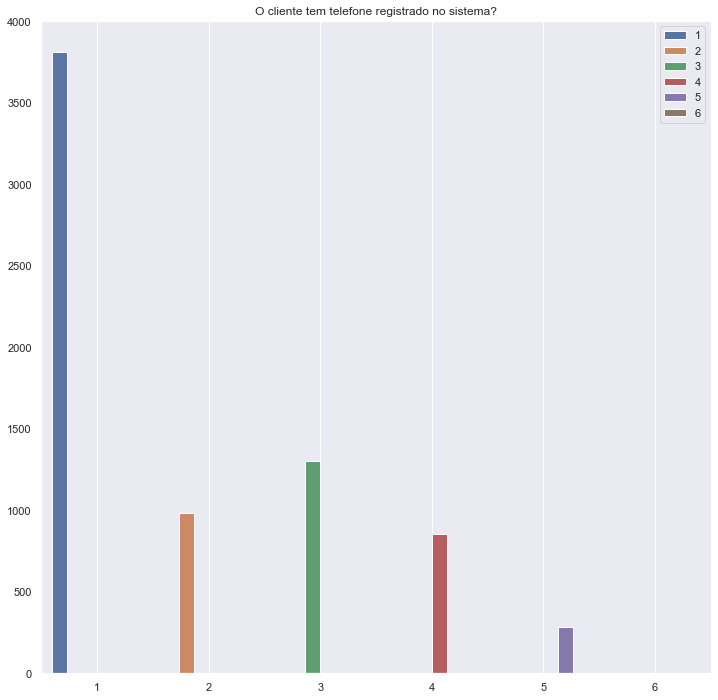

In [150]:
sns.set(style="darkgrid")

fig = sns.barplot(x=list(check_crd),
                  y=[check_crd['1'].iloc[0],
                     check_crd['2'].iloc[0],
                     check_crd['3'].iloc[0],
                     check_crd['4'].iloc[0],
                     check_crd['5'].iloc[0],
                     check_crd['6'].iloc[0]],
                     hue=list(check_crd))
plt.grid(None)
plt.title("O cliente tem telefone registrado no sistema?")
plt.rcParams["figure.figsize"] = (12,12)
plt.show(fig)

#### Questão x: De acordo com os insights obtidos nas questões anteriores, quais serão as decisões de tratamento a serem adotadas nos dados?



# Tratamento de Dados

O tratamento de dados pode ser construídos de 2 formas, a primeira trataria variáveis categóricas associadas a um id como 0 ou 1, seguindo a lógica de um "One Hot Encoder". Outra maneira, seria determinar índices associados a uma determinada variável categórica como, por exemplo: 0 - não informado, 1 - ruim, 2 - médio, 3 - bom.

## Tratamento de Dados 1 - Preparando a variável categórica 'histórico de crédito' para o modelo de classificação

In [22]:
from sklearn.ensemble import RandomForestRegressor

In [23]:
# Caso seja necessário descomente e execute o comando abaixo. 
# Feito isso, será necessário reiniciar o notebook e executá-lo novamente
#pip install --upgrade category_encoders

In [24]:
from category_encoders.one_hot import OneHotEncoder

In [25]:
enc = OneHotEncoder(cols=['CREDIT_HISTORY'], use_cat_names=True)
enc.fit(df1)

OneHotEncoder(cols=['CREDIT_HISTORY'], use_cat_names=True)

In [26]:
df1['CREDIT_HISTORY'].nunique()

5

In [27]:
new_df1 = enc.transform(df1)
new_df1

,ID,CHECKING_BALANCE,CREDIT_HISTORY_ALL_CREDITS_PAID_BACK,CREDIT_HISTORY_CREDITS_PAID_TO_DATE,CREDIT_HISTORY_PRIOR_PAYMENTS_DELAYED,CREDIT_HISTORY_OUTSTANDING_CREDIT,CREDIT_HISTORY_NO_CREDITS,CREDIT_HISTORY_nan,EXISTING_SAVINGS,EXISTING_CREDITS_COUNT
0,291655,-566.53,1,0,0,0,0,0,36.42,1.0
1,657079,-1673.16,0,1,0,0,0,0,22.9,1.0
2,256050,NO_CHECKING,0,1,0,0,0,0,450.35,2.0
3,1039151,-1471.03,0,0,1,0,0,0,805.71,2.0
4,1002660,NO_CHECKING,0,1,0,0,0,0,295.03,1.0
...,...,...,...,...,...,...,...,...,...,...
2472,636739,163.82,0,1,0,0,0,0,472.11,1.0
2473,919733,14324.23,0,0,1,0,0,0,18652.44,1.0
2474,115839,130.13,0,0,1,0,0,0,726.78,2.0
2475,1128684,NO_CHECKING,0,0,1,0,0,0,UNKNOWN,1.0
